In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Read files with training dataset and cancer labels into pandas DataFrames
file = 'data_set_ALL_AML_train.csv'
data = pd.read_csv(file, index_col=1)
key = pd.read_csv('actual.csv', index_col=0)

# Set plot defaults
sns.set()                       # sets default plot style
sns.set_context("paper")        # sets default plot context
plt.rc('figure', figsize=(16,8))# sets default figure size
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc(['xtick', 'ytick'], labelsize=12)   # fontsize of the tick labels
plt.rc('legend', fontsize=16)   # fontsize of the legend labels

# Remove 'call' columns from DataFrame
a = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = data.drop(columns=a)

# Remove microarray controls (indicated by 'AFFX') from DataFrame rows
controls = []
for entry in data.index:
    if 'AFFX' in entry:
        controls.append(entry)
controls.append('hum_alu_at')
data = data.drop(labels=controls, axis=0)

# Drop the 'Gene Description' row as it is not useful here
data = data.drop(['Gene Description'], axis=1)

# Map the column entries to integers and sort the index
data.columns = data.columns.map(int)
data.sort_index(axis=1, inplace=True)

# Transpose rows and columns so that each column is a different gene
transposed_data = data.transpose()

# Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, transposed_data], axis=1, join='inner')

# Group by cancer type to aggregate and calculate mean and std for both cancer types
df_agg = exp_data.groupby('cancer').agg(['mean', 'std'])

I first wanted to get an idea of what the gene expression data looked like for the ALL and AML cancers. As there are 7129 genes in the dataset, the best way to get a 'big picture' view of the data is to plot the empirical cumulative distribution function (ECDF) for the mean gene expression data for each of the cancer types. As expected, the two ECDFs look very similar; both cancer types display a range of gene expression levels, with some genes having very low expression and some genes having very high expression. The majority of the genes, approximately 40%, have expression levels between 100 to 1000, while a little under 15% of the genes are very highly expressed.

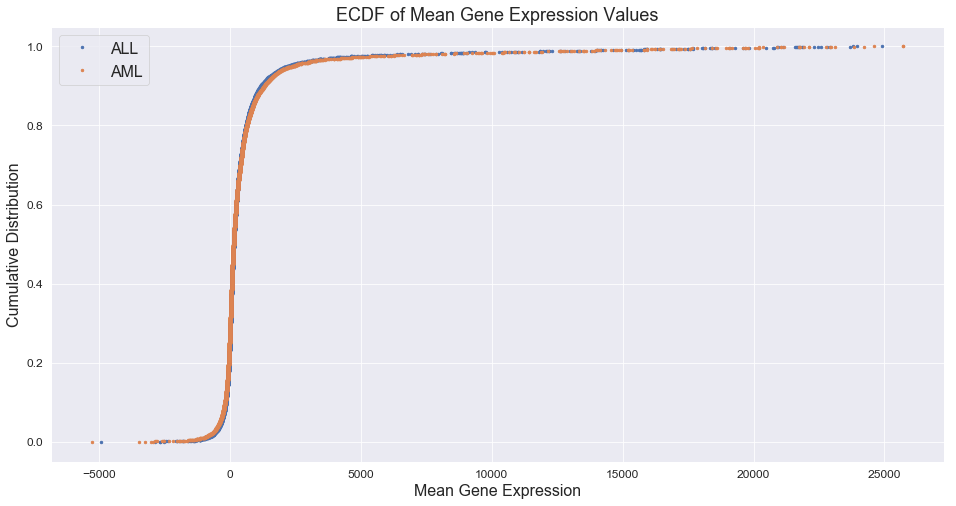

In [3]:
# Transpose dataframe so that genes form the rows
df_agg = df_agg.transpose()
# Drop outlier gene with high negative expression levels
df_agg = df_agg.drop(['HG2887-HT3031_at'])

# Plot the empirical cumulative distribution function (ECDF) for ALL and AML mean gene expression
# First, slice out and sort ALL mean data and AML mean data to use as x-values of EDCF plots
ALL_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'ALL'])
AML_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'AML'])

#Calculate y-values for ECDF plots (evenly-spaced y-values with a maximum of 1)
y = (np.arange(1, len(ALL_mean)+1)) / len(ALL_mean)

#Generate the ALL and AML ECDF plots
plt.figure(figsize=(16, 8))
plt.plot(ALL_mean, y, marker='.', linestyle='none', label='ALL')
plt.plot(AML_mean, y, marker='.', linestyle='none', label='AML')

# Label axes, add title & legend, then save & display the plots
plt.xlabel('Mean Gene Expression')
plt.ylabel('Cumulative Distribution')
plt.title('ECDF of Mean Gene Expression Values')
plt.legend()
plt.show()

I then wanted to be able to estimate the correlation between genes and cancer type to determine which genes were most highly correlated with the ALL and AML cancer types. 

The correlation estimate must account for not only the difference in the ALL and AML mean expression level but also for the standard deviations of these means. To estimate the correlation of each gene, I calculated the difference between the means and divided it by the sum of the standard deviation of the means - this measure of correlation emphasizes the 'signal-to-noise' ratio:

$$ (\mu_{ALL} - \mu_{AML}) / (\sigma_{ALL} + \sigma_{AML}) $$

I then plotted a histogram of the correlation values to see the correlation distribution. As you can see from the graph below, the absolute values of the correlation values for most genes is low, and the histogram is centered around zero. Genes with high positive correlation values are more highly expressed in the ALL samples, while genes with high negative correlation values are more highly expressed in the AML samples.

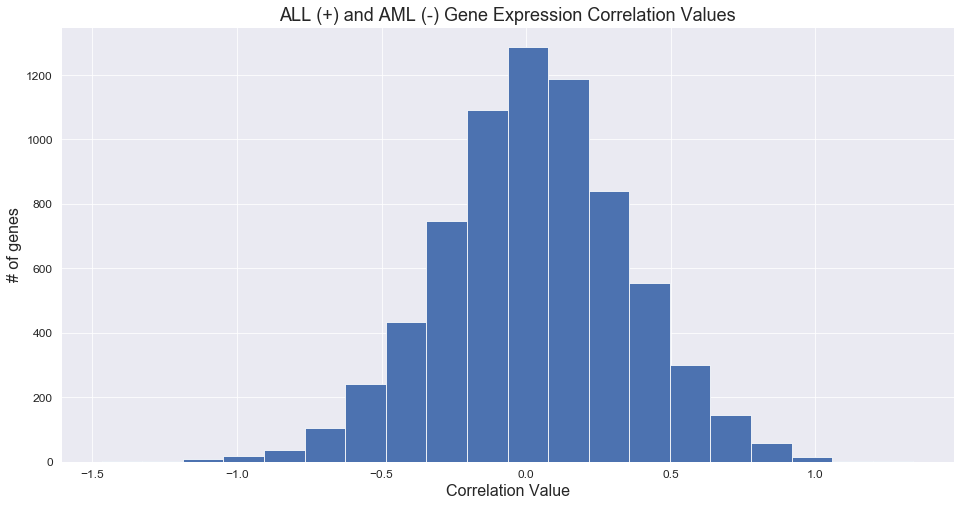

In [4]:
#Calculate the difference of ALL mean to AML mean for all genes and save in a new column, ALL:AML
df_agg.loc[(slice(None), 'mean'), 'ALL:AML'] = (df_agg['ALL'] - df_agg['AML'])
#Calculate the sum of ALL std to AML std for all genes and save column ALL:AML
df_agg.loc[(slice(None), 'std'), 'ALL:AML'] = (df_agg['ALL'] + df_agg['AML'])

mean_diff = df_agg.loc[(slice(None), 'mean'), 'ALL:AML'].copy()
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = df_agg.loc[(slice(None), 'std'), 'ALL:AML'].copy()
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

#Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)

#Plot a histogram and line plot of the correlation for each gene
plt.figure(figsize=(16,8))
plt.hist(df_corr['correlation'], bins=20)
plt.title('ALL (+) and AML (-) Gene Expression Correlation Values')
plt.xlabel('Correlation Value')
plt.ylabel('# of genes')
plt.show()

Another way to visualize the correlation values is through the ECDF plots. In the graphs below, you can see that both the ALL and AML cancers have over 500 genes with correlation values of 0.5 or higher. The inverse of the correlation value dataset was used to calculate the ECDF of ALL cancer so that the correlation values could be easily sorted and plotted alongside the AML ECDF - the sign of the correlation value is irrelevant in this plot, as the sign merely indicates the cancer type that the gene is correlated with (negative correlation values for AML cancer and positive correlation values for ALL cancer).

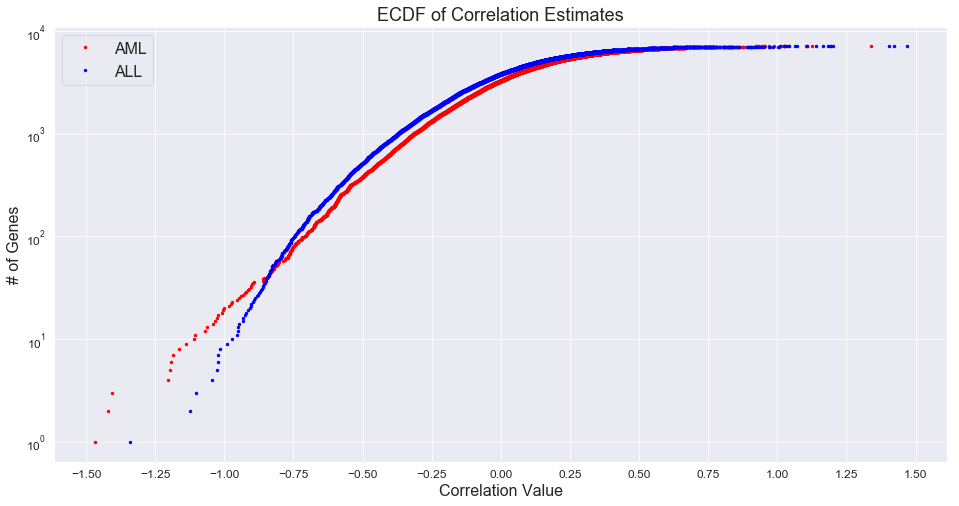

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)
    # x-data for the ECDF
    x = np.sort(data)
    # y-data for the ECDF
    y = np.arange(1, n+1)

    return x, y

AML_corr = df_corr['correlation']
ALL_corr = [-x for x in AML_corr]

# Create and plot ECDFs from original data
AML_x, AML_y = ecdf(AML_corr)
ALL_x, ALL_y = ecdf(ALL_corr)

plt.figure(figsize=(16, 8))
plt.plot(AML_x, AML_y, marker='.', linestyle='none', label='AML', color='red')
plt.plot(ALL_x, ALL_y, marker='.', linestyle='none', label='ALL', color='blue')
ax = plt.yscale('log')
plt.xlabel('Correlation Value')
plt.xticks(np.arange(-1.5, 1.75, step=0.25))
plt.ylabel('# of Genes')
plt.title('ECDF of Correlation Estimates')
plt.legend()
plt.savefig(fname='correlation_ECDF.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

As I am only interested in the genes that are most highly correlated with the ALL/AML distinction, I have selected the top 25 genes correlated with ALL cancer and the top 25 genes correlated with AML cancer. I will explore these top 50 genes in more detail in the following sections.

First, I want to assess the probability of getting the calculated correlation values for the top 50 genes. I will do this by assuming that the gene expression levels of the ALL and AML samples have identical probability distributions and calculating the correlation values on permutations of the combined expression level data for each gene. 

Null hypothesis: The gene expression levels of the ALL and AML samples have identical probability distributions.  
Test statistic: $ (\mu_{ALL} - \mu_{AML}) / (\sigma_{ALL} + \sigma_{AML}) $

I have calculated p-values (the probability of the getting the observed correlation values if there is no difference between ALL and AML cancer) by dividing the number of permutation samples that resulted in correlation values at least as extreme as the observed value by the total number of permutations performed. After performing 10,000 permutations and calculating p-values for each of the top 50 genes, I only see 1-2 permutations at most that have correlation values as extreme as the observed values. Therefore, the p-values are small enough that they are much less than 0.001.

I have also used bootstrap analysis to calculate the confidence intervals for the correlation values for each of the top 50 genes. For these calculations, I took bootstrap replicates of both the ALL and AML gene expression levels, and then used these replicates to calculate the resulting correlation values. I computed 10,000 of these bootstrap replicates for the correlation value and then determined the 95% confidence interval of the resulting distribution.

In [6]:
import random
random.seed(2158)

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates

def corr_value(data1, data2):
    """Calculate correlation value"""
    
    corr_value = (np.mean(data1) - np.mean(data2)) / (np.std(data1, ddof=1) + np.std(data2, ddof=1))
    corr_value = round(corr_value, 2)
    return corr_value

df_corr_sorted = df_corr.sort_values(by=['correlation'])
df_corr_top = pd.concat([df_corr_sorted.head(25), df_corr_sorted.tail(25)])
data_top = data.loc[df_corr_top.index, :]

p_values = pd.DataFrame(index=data_top.index, columns=['correlation', 'pvalue', '95_ci'])

for index, row in data_top.iterrows():
    empirical_corr = corr_value(row[:27], row[27:])
    p_values.loc[index, 'correlation'] = empirical_corr
    perm_replicates = draw_perm_reps(row[:27], row[27:], corr_value, 10000)
    p_values.loc[index, 'pvalue'] = np.sum(abs(perm_replicates) >= abs(empirical_corr)) / len(perm_replicates)

In [7]:
def draw_bs_reps_2d(data1, data2, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_sample_ALL = np.random.choice(data1, len(data1))
        bs_sample_AML = np.random.choice(data2, len(data2))
        bs_replicates[i] = func(bs_sample_ALL, bs_sample_AML)

    return bs_replicates

for index, row in data_top.iterrows():
    bs_replicates = draw_bs_reps_2d(row[:27], row[27:], corr_value, 10000)
    conf_int = np.percentile(bs_replicates, (2.5, 97.5))
    p_values.loc[index, '95_ci'] = np.around(conf_int, decimals=3)

p_values

,correlation,pvalue,95_ci
M55150_at,-1.47,0,"[-2.25, -1.13]"
U50136_rna1_at,-1.42,0,"[-2.22, -1.06]"
X95735_at,-1.41,0,"[-2.2, -1.09]"
M16038_at,-1.2,0,"[-1.95, -0.85]"
M23197_at,-1.2,0,"[-1.89, -0.88]"
M84526_at,-1.19,0,"[-2.19, -0.73]"
Y12670_at,-1.18,0,"[-1.85, -0.92]"
U82759_at,-1.16,0,"[-1.98, -0.74]"
D49950_at,-1.14,0,"[-2.23, -0.69]"
M27891_at,-1.11,0,"[-1.82, -0.77]"


C:\Users\Caitlin\Miniconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


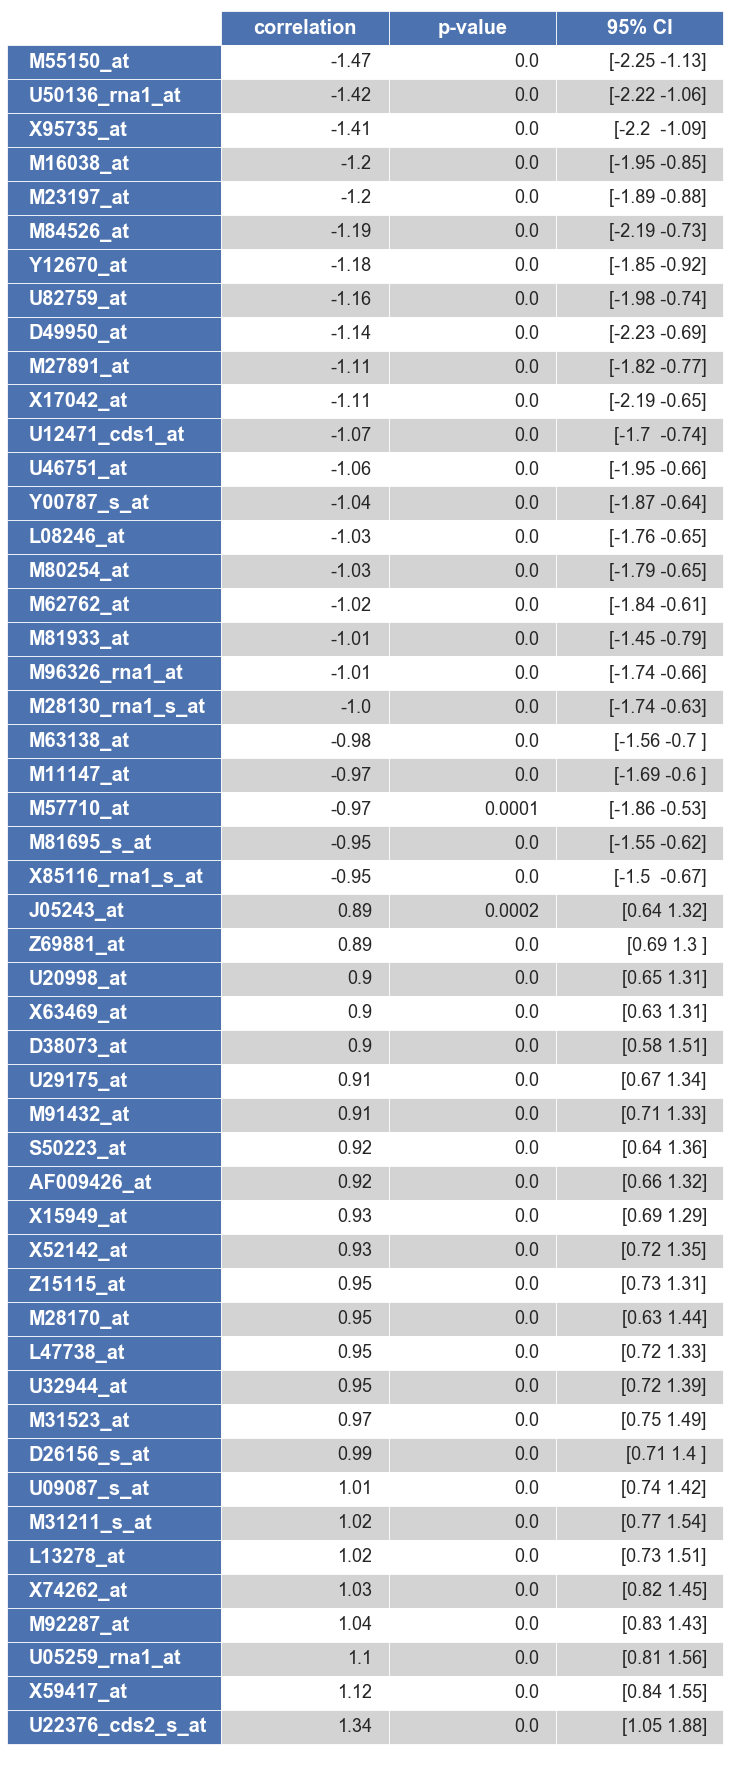

In [8]:
# Method to write panadas dataframe to a table and return
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=18,
                     header_color='b', row_colors=['lightgray', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, colLabels=data.columns, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=colLabels, rowLabels=data.index)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', size=20)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

# Write p_values to a table and export
colLabels = ['correlation', 'p-value', '95% CI']
render_mpl_table(p_values, header_columns=0, colLabels=colLabels)
plt.savefig(fname='pvalue_table.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)

Finally, I have also assessed the probability of getting the observed mean expression levels for each of the top 50 genes as well as the confidence intervals for each gene. For these calculations, I used bootstrap analysis to generate 10,000 replicates of the mean expression level for each gene, and then used these replicates to calculate the 95% confidence intervals.

I then used a two-sample bootstrap hypothesis test to assess whether the true mean expression levels for ALL and AML cancers were actually the same. To do this, I first shifted the means of both the ALL and AML samples so that both datasets had the same mean. I then drew 10,000 bootstrap samples out of each shifted array and calculated the difference in means.

Null Hypothesis: The true gene expression level means are the same for ALL and AML cancer.  
Test statistic: $(\mu_{ALL} - \mu_{AML})$

As you can see below, at most only a few of the bootstrap replicates out of 10,000 resulted in a mean difference at least as large as the observed mean difference. For most of the genes, none of the bootstrap replicates were as large as the observed difference. Therefore, the means of the ALL and AML expression levels for these 50 genes are different.

In [9]:
def draw_bs_reps_1d(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)

    return bs_replicates

columns = ['ALL_mean', 'ALL_95_ci', 'AML_mean', 'AML_95_ci', 'mean_diff', 'p_value']
mean_stats = pd.DataFrame(index=data_top.index, columns=columns)

# Iterate over top genes and calculate 95% confidence intervals on the ALL and AML mean expression levels
for index, row in data_top.iterrows():
    # Separate row into ALL and AML datasets
    ALL = row[:27]
    AML = row[27:]
    
    # Calculate ALL and AML means and difference of the means
    ALL_mean, AML_mean = np.mean(ALL), np.mean(AML)
    mean_diff = ALL_mean - AML_mean
    
    # Save means and mean_diff in appropriate columns in DataFrame
    mean_stats.loc[index, 'ALL_mean'] = ALL_mean
    mean_stats.loc[index, 'AML_mean'] = AML_mean
    mean_stats.loc[index, 'mean_diff'] = mean_diff
    
    # Calculate 10,000 bootstrap replicates for both ALL and AML samples
    bs_replicates_ALL = draw_bs_reps_1d(ALL, np.mean, 10000)
    bs_replicates_AML = draw_bs_reps_1d(AML, np.mean, 10000)
    
    # Caluculate 95% confidence intervals for each mean distribution
    mean_stats.loc[index, 'ALL_95_ci'] = np.around(np.percentile(bs_replicates_ALL, (2.5, 97.5)), decimals=3)
    mean_stats.loc[index, 'AML_95_ci'] = np.around(np.percentile(bs_replicates_AML, (2.5, 97.5)), decimals=3)

# Iterate over top genes and calculate p_value for null hypothesis (i.e. the true ALL and AML means are the same)
for index, row in data_top.iterrows():
    # Compute mean of all expression levels
    mean_expression = np.mean(row)

    # Calculate empirical difference of means
    empirical_diff_means = abs(np.mean(row[:27]) - np.mean(row[27:]))

    # Generate shifted arrays
    ALL_shifted = row[:27] - np.mean(row[:27]) + mean_expression
    AML_shifted = row[27:] - np.mean(row[27:]) + mean_expression

    # Compute 10,000 bootstrap replicates from shifted arrays
    bs_replicates_ALL = draw_bs_reps_1d(ALL_shifted, np.mean, 10000)
    bs_replicates_AML = draw_bs_reps_1d(AML_shifted, np.mean, 10000)

    # Get replicates of difference of means: bs_replicates
    bs_replicates = abs(bs_replicates_ALL - bs_replicates_AML)

    # Compute and print p-value
    p = np.sum(bs_replicates >= empirical_diff_means ) / 10000
    mean_stats.loc[index, 'p_value'] = p
    
mean_stats

,ALL_mean,ALL_95_ci,AML_mean,AML_95_ci,mean_diff,p_value
M55150_at,810.296,"[688.629, 938.446]",1836.27,"[1649.359, 2062.82]",-1025.98,0
U50136_rna1_at,977.778,"[862.629, 1102.817]",2562.18,"[2126.086, 3021.577]",-1584.4,0
X95735_at,349.889,"[202.141, 492.264]",3023.64,"[2222.877, 3908.109]",-2673.75,0
M16038_at,375.37,"[288.555, 465.744]",1811.64,"[1264.543, 2352.564]",-1436.27,0
M23197_at,175.037,"[145.481, 207.448]",767.273,"[542.63, 1004.464]",-592.236,0
M84526_at,-177.407,"[-243.446, -113.555]",3483,"[1873.902, 5065.548]",-3660.41,0
Y12670_at,411.148,"[335.74, 491.151]",1294.45,"[1028.452, 1622.009]",-883.306,0
U82759_at,241.37,"[153.958, 331.336]",850.727,"[684.998, 1007.28]",-609.357,0
D49950_at,75.3704,"[56.037, 96.519]",243.909,"[187.636, 293.457]",-168.539,0
M27891_at,144.444,"[-2.444, 314.336]",7423.55,"[4095.4, 11047.589]",-7279.1,0.0001
